# 第二讲：神经网络优化

## 1 神经网络复杂度

### 1.1 时间复杂度

## 1.2 空间复杂度

## 2 学习率策略

### 2.1 指数衰减

TensorFlow API: tf.keras.optimizers.schedules.ExponentialDecay

### 2.2 分段常数衰减

TensorFlow API: tf.optimizers.schedules.PiecewiseConstantDecay

## 3 激活函数

### 3.1 sigmoid

### 3.2 tanh

### 3.3 ReLU

### 3.4 Leaky ReLU

### 3.5 softmax

### 3.6 建议

## 4 损失函数

### 4.1 均方误差损失函数

### 4.2 交叉熵损失函数

### 4.3 自定义损失函数

## 5 欠拟合与过拟合

## 6 优化器

### 6.1 SGD

#### 6.1.1 vanilla SGD

Epoch:0, loss: 0.282131090760231
Test_acc: 0.16666666666666666
--------------------------
Epoch:1, loss: 0.25459614396095276
Test_acc: 0.16666666666666666
--------------------------
Epoch:2, loss: 0.22570250183343887
Test_acc: 0.16666666666666666
--------------------------
Epoch:3, loss: 0.21028399094939232
Test_acc: 0.16666666666666666
--------------------------
Epoch:4, loss: 0.19942265003919601
Test_acc: 0.16666666666666666
--------------------------
Epoch:5, loss: 0.18873638287186623
Test_acc: 0.5
--------------------------
Epoch:6, loss: 0.17851299792528152
Test_acc: 0.5333333333333333
--------------------------
Epoch:7, loss: 0.16922876238822937
Test_acc: 0.5333333333333333
--------------------------
Epoch:8, loss: 0.16107673570513725
Test_acc: 0.5333333333333333
--------------------------
Epoch:9, loss: 0.15404684469103813
Test_acc: 0.5333333333333333
--------------------------
Epoch:10, loss: 0.14802725985646248
Test_acc: 0.5333333333333333
--------------------------
Epoch:11, 

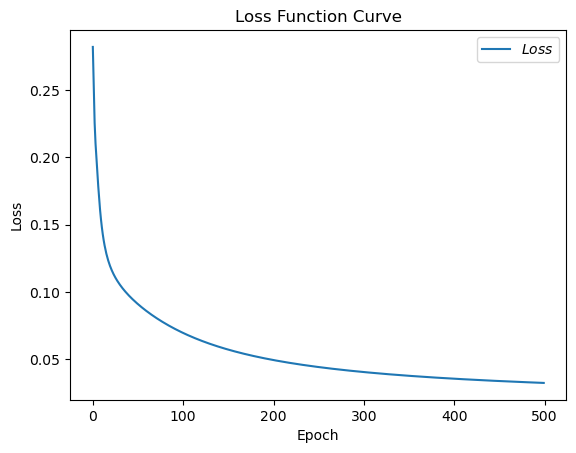

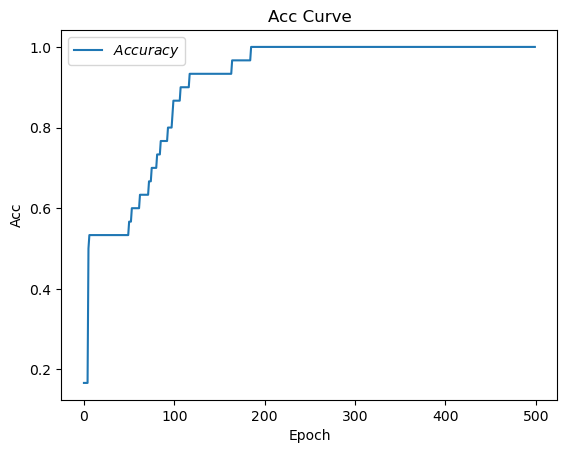

In [42]:
# 利用鸢尾花数据集，实现前向传播、反向传播，可视化loss曲线

# 导入所需模块
import tensorflow as tf
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np
import time

# 导入数据，分别为输入特征和标签
x_data = datasets.load_iris().data 
y_data = datasets.load_iris().target

 # 随机打乱数据（因为原始数据是顺序的，顺序不打乱会影响准确率）
# seed: 随机数种子，是一个整数，当设置之后，每次生成的随机数都一样（为方便教学，以保每位同学结果一致）
np.random.seed(116)  # 使用相同的seed，保证输入特征和标签一一对应
np.random.shuffle(x_data)
np.random.seed(116)
np.random.shuffle(y_data)
tf.random.set_seed(116)

# 将打乱后的数据集分割为训练集和测试集，训练集为前120行，测试集为后30行
x_train = x_data[:-30]
y_train = y_data[:-30]
x_test = x_data[-30:]
y_test = y_data[-30:]

# 转换x的数据类型，否则后面矩阵相乘时会因数据类型不一致报错
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)


# from_tensor_slices函数使输入特征和标签值一一对应。（把数据集分批次，每个批次batch组数据）
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# 生成神经网络的参数，4个输入特征故，输入层为4个输入节点；因为3分类，故输出层为3个神经元
# 用tf.Variable()标记参数可训练
# 使用seed使每次生成的随机数相同（方便教学，使大家结果都一致，在现实使用时不写seed）
w1 = tf.Variable(tf.random.truncated_normal([4, 3], stddev=0.1, seed=1))
b1 = tf.Variable(tf.random.truncated_normal([3], stddev=0.1, seed=1))

lr = 0.1 # 学习率为0.1
train_loss_results = [] # 将每轮的loss记录在此列表中，为后续画loss曲线提供数据
test_acc = [] # 将每轮的acc记录在此列表中，为后续画acc曲线提供数据
epoch = 500 # 循环500轮
loss_all = 0 # 每轮分4个step，loss_all记录四个step生成的4个loss的和

# 训练部分
now_time = time.time()
for epoch in range(epoch): # 数据集级别的循环，每个epoch循环一次数据集
    for step, (x_train, y_train) in enumerate(train_db):
        with tf.GradientTape() as tape: # with结构记录梯度信息
            y = tf.matmul(x_train, w1) + b1 # 神经网络乘加运算
            y = tf.nn.softmax(y) # 使输出y符合概率分布（此操作后与独热码同量级，可相减求loss）
            y_ = tf.one_hot(y_train, depth=3)  # 将标签值转换为独热码格式，方便计算loss和accuracy
            loss = tf.reduce_mean(tf.square(y_ - y))  # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_all += loss.numpy()  # 将每个step计算出的loss累加，为后续求loss平均值提供数据，这样计算的loss更准确
        # 计算loss对各个参数的梯度
        grads = tape.gradient(loss, [w1, b1])
        
        # 实现梯度更新 w1 = w1 - lr * w1_grad    b = b - lr * b_grad
        w1.assign_sub(lr * grads[0]) # 参数w1自更新
        b1.assign_sub(lr * grads[1]) # 参数b自更新
                    
    # 每个epoch，打印loss信息
    print("Epoch:{}, loss: {}".format(epoch, loss_all / 4))
    train_loss_results.append(loss_all / 4) # 将4个step的loss求平均记录在此变量中
    loss_all = 0  # loss_all归零，为记录下一个epoch的loss做准备

    # 测试部分
    # total_correct为预测对的样本个数, total_number为测试的总样本数，将这两个变量都初始化为0
    total_correct, total_number = 0, 0
    for x_test, y_test in test_db:
        # 使用更新后的参数进行预测
        y = tf.matmul(x_test, w1) + b1
        y = tf.nn.softmax(y)
        pred = tf.argmax(y, axis=1) # 返回y中最大值的索引，即预测的分类
        # 将pred转换为y_test的数据类型
        pred = tf.cast(pred, dtype=y_test.dtype)
        # 若分类正确，则correct=1，否则为0，将bool型的结果转换为int型
        correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
        # 将每个batch的correct数加起来
        correct = tf.reduce_sum(correct)
        # 将所有batch中的correct数加起来
        total_correct += int(correct)
        # total_number为测试的总样本数，也就是x_test的行数，shape[0]返回变量的行数
        total_number += x_test.shape[0]
    # 总的准确率等于total_correct/total_number
    acc = total_correct / total_number
    test_acc.append(acc)
    print("Test_acc:", acc)
    print("--------------------------")
total_time = time.time() - now_time
print("total_time", total_time)
    

# 绘制 loss 曲线
plt.title('Loss Function Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Loss')  # y轴变量名称
plt.plot(train_loss_results, label="$Loss$")  # 逐点画出trian_loss_results值并连线，连线图标是Loss
plt.legend()  # 画出曲线图标
plt.show()  # 画出图像

# 绘制 Accuracy 曲线
plt.title('Acc Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Acc')  # y轴变量名称
plt.plot(test_acc, label="$Accuracy$")  # 逐点画出test_acc值并连线，连线图标是Accuracy
plt.legend()
plt.show()

# 本文件较 class1\p45_iris.py 仅添加四处时间记录  用 ##n## 标识
# 请将loss曲线、ACC曲线、total_time记录到 class2\优化器对比.docx  对比各优化器收敛情况

#### 6.1.2 SGD with Momentum

Epoch:0, loss: 0.2961867153644562
Test_acc: 0.16666666666666666
--------------------------
Epoch:1, loss: 0.28081152215600014
Test_acc: 0.16666666666666666
--------------------------
Epoch:2, loss: 0.26392311230301857
Test_acc: 0.16666666666666666
--------------------------
Epoch:3, loss: 0.241925410926342
Test_acc: 0.16666666666666666
--------------------------
Epoch:4, loss: 0.2185598537325859
Test_acc: 0.16666666666666666
--------------------------
Epoch:5, loss: 0.20465286821126938
Test_acc: 0.16666666666666666
--------------------------
Epoch:6, loss: 0.1955692060291767
Test_acc: 0.16666666666666666
--------------------------
Epoch:7, loss: 0.18339978531002998
Test_acc: 0.5
--------------------------
Epoch:8, loss: 0.17289477959275246
Test_acc: 0.5333333333333333
--------------------------
Epoch:9, loss: 0.1638195775449276
Test_acc: 0.5333333333333333
--------------------------
Epoch:10, loss: 0.1557205766439438
Test_acc: 0.5333333333333333
--------------------------
Epoch:11, los

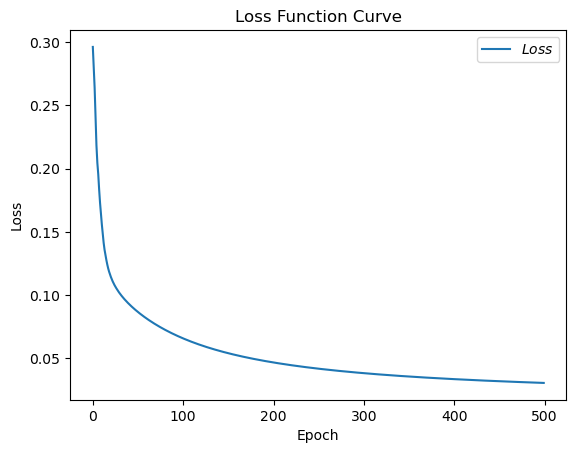

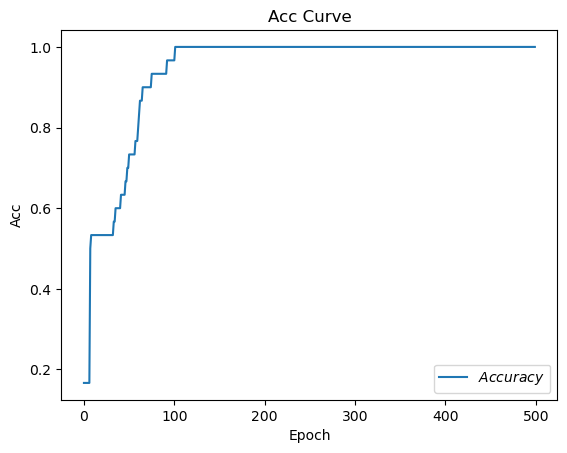

In [44]:
# 利用鸢尾花数据集，实现前向传播、反向传播，可视化loss曲线

# 导入所需模块
import tensorflow as tf
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np
import time

# 导入数据，分别为输入特征和标签
x_data = datasets.load_iris().data 
y_data = datasets.load_iris().target

 # 随机打乱数据（因为原始数据是顺序的，顺序不打乱会影响准确率）
# seed: 随机数种子，是一个整数，当设置之后，每次生成的随机数都一样（为方便教学，以保每位同学结果一致）
np.random.seed(116)  # 使用相同的seed，保证输入特征和标签一一对应
np.random.shuffle(x_data)
np.random.seed(116)
np.random.shuffle(y_data)
tf.random.set_seed(116)

# 将打乱后的数据集分割为训练集和测试集，训练集为前120行，测试集为后30行
x_train = x_data[:-30]
y_train = y_data[:-30]
x_test = x_data[-30:]
y_test = y_data[-30:]

# 转换x的数据类型，否则后面矩阵相乘时会因数据类型不一致报错
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)


# from_tensor_slices函数使输入特征和标签值一一对应。（把数据集分批次，每个批次batch组数据）
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# 生成神经网络的参数，4个输入特征故，输入层为4个输入节点；因为3分类，故输出层为3个神经元
# 用tf.Variable()标记参数可训练
# 使用seed使每次生成的随机数相同（方便教学，使大家结果都一致，在现实使用时不写seed）
w1 = tf.Variable(tf.random.truncated_normal([4, 3], stddev=0.1, seed=1))
b1 = tf.Variable(tf.random.truncated_normal([3], stddev=0.1, seed=1))

lr = 0.1 # 学习率为0.1
train_loss_results = [] # 将每轮的loss记录在此列表中，为后续画loss曲线提供数据
test_acc = [] # 将每轮的acc记录在此列表中，为后续画acc曲线提供数据
epoch = 500 # 循环500轮
loss_all = 0 # 每轮分4个step，loss_all记录四个step生成的4个loss的和

#########################################################################
m_w, m_b = 0, 0
beta = 0.9
#########################################################################

# 训练部分
now_time = time.time()
for epoch in range(epoch): # 数据集级别的循环，每个epoch循环一次数据集
    for step, (x_train, y_train) in enumerate(train_db):
        with tf.GradientTape() as tape: # with结构记录梯度信息
            y = tf.matmul(x_train, w1) + b1 # 神经网络乘加运算
            y = tf.nn.softmax(y) # 使输出y符合概率分布（此操作后与独热码同量级，可相减求loss）
            y_ = tf.one_hot(y_train, depth=3)  # 将标签值转换为独热码格式，方便计算loss和accuracy
            loss = tf.reduce_mean(tf.square(y_ - y))  # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_all += loss.numpy()  # 将每个step计算出的loss累加，为后续求loss平均值提供数据，这样计算的loss更准确
        # 计算loss对各个参数的梯度
        grads = tape.gradient(loss, [w1, b1])
        
        ##########################################
        #sgd-momentun
        m_w = beta * m_w + (1 - beta) * grads[0]
        m_b = beta * m_b + (1 - beta) * grads[1]
        w1.assign_sub(lr * m_w) # 参数w1自更新
        b1.assign_sub(lr * m_b) # 参数b自更新
        ##########################################
                    
    # 每个epoch，打印loss信息
    print("Epoch:{}, loss: {}".format(epoch, loss_all / 4))
    train_loss_results.append(loss_all / 4) # 将4个step的loss求平均记录在此变量中
    loss_all = 0  # loss_all归零，为记录下一个epoch的loss做准备

    # 测试部分
    # total_correct为预测对的样本个数, total_number为测试的总样本数，将这两个变量都初始化为0
    total_correct, total_number = 0, 0
    for x_test, y_test in test_db:
        # 使用更新后的参数进行预测
        y = tf.matmul(x_test, w1) + b1
        y = tf.nn.softmax(y)
        pred = tf.argmax(y, axis=1) # 返回y中最大值的索引，即预测的分类
        # 将pred转换为y_test的数据类型
        pred = tf.cast(pred, dtype=y_test.dtype)
        # 若分类正确，则correct=1，否则为0，将bool型的结果转换为int型
        correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
        # 将每个batch的correct数加起来
        correct = tf.reduce_sum(correct)
        # 将所有batch中的correct数加起来
        total_correct += int(correct)
        # total_number为测试的总样本数，也就是x_test的行数，shape[0]返回变量的行数
        total_number += x_test.shape[0]
    # 总的准确率等于total_correct/total_number
    acc = total_correct / total_number
    test_acc.append(acc)
    print("Test_acc:", acc)
    print("--------------------------")
total_time = time.time() - now_time
print("total_time", total_time)
    

# 绘制 loss 曲线
plt.title('Loss Function Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Loss')  # y轴变量名称
plt.plot(train_loss_results, label="$Loss$")  # 逐点画出trian_loss_results值并连线，连线图标是Loss
plt.legend()  # 画出曲线图标
plt.show()  # 画出图像

# 绘制 Accuracy 曲线
plt.title('Acc Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Acc')  # y轴变量名称
plt.plot(test_acc, label="$Accuracy$")  # 逐点画出test_acc值并连线，连线图标是Accuracy
plt.legend()
plt.show()

# 本文件较 class1\p45_iris.py 仅添加四处时间记录  用 ##n## 标识
# 请将loss曲线、ACC曲线、total_time记录到 class2\优化器对比.docx  对比各优化器收敛情况

#### 6.1.3 SGD with Mesterov Accelerration

### 6.2 AdaGrad

Epoch:0, loss: 0.2528788559138775
Test_acc: 0.5333333333333333
--------------------------
Epoch:1, loss: 0.17821526154875755
Test_acc: 0.5333333333333333
--------------------------
Epoch:2, loss: 0.15621443092823029
Test_acc: 0.5333333333333333
--------------------------
Epoch:3, loss: 0.1420477256178856
Test_acc: 0.5333333333333333
--------------------------
Epoch:4, loss: 0.13362514227628708
Test_acc: 0.5333333333333333
--------------------------
Epoch:5, loss: 0.12754761055111885
Test_acc: 0.5333333333333333
--------------------------
Epoch:6, loss: 0.12286805547773838
Test_acc: 0.5333333333333333
--------------------------
Epoch:7, loss: 0.11908591166138649
Test_acc: 0.5333333333333333
--------------------------
Epoch:8, loss: 0.1159136202186346
Test_acc: 0.5333333333333333
--------------------------
Epoch:9, loss: 0.11317718587815762
Test_acc: 0.5333333333333333
--------------------------
Epoch:10, loss: 0.11076571047306061
Test_acc: 0.5333333333333333
--------------------------
E

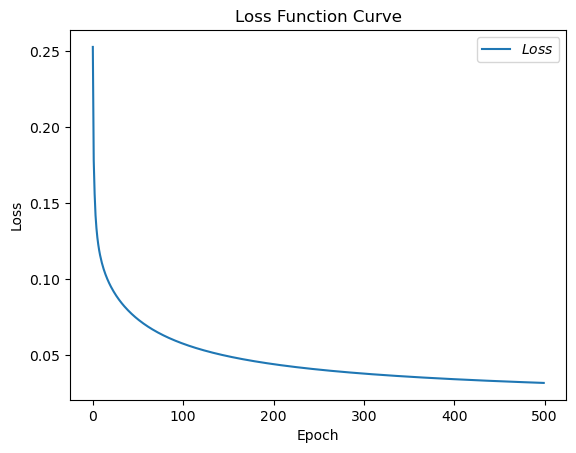

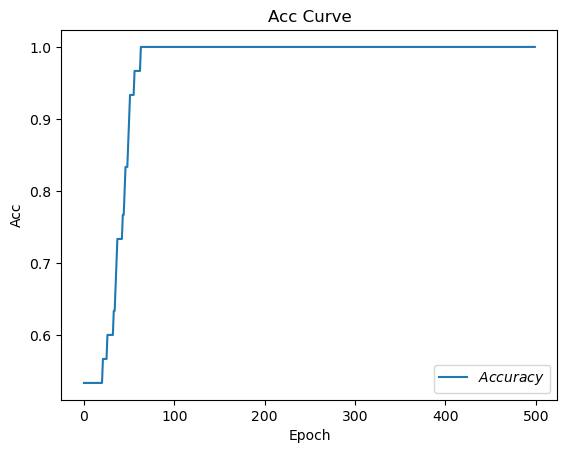

In [45]:
# 利用鸢尾花数据集，实现前向传播、反向传播，可视化loss曲线

# 导入所需模块
import tensorflow as tf
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np
import time

# 导入数据，分别为输入特征和标签
x_data = datasets.load_iris().data 
y_data = datasets.load_iris().target

 # 随机打乱数据（因为原始数据是顺序的，顺序不打乱会影响准确率）
# seed: 随机数种子，是一个整数，当设置之后，每次生成的随机数都一样（为方便教学，以保每位同学结果一致）
np.random.seed(116)  # 使用相同的seed，保证输入特征和标签一一对应
np.random.shuffle(x_data)
np.random.seed(116)
np.random.shuffle(y_data)
tf.random.set_seed(116)

# 将打乱后的数据集分割为训练集和测试集，训练集为前120行，测试集为后30行
x_train = x_data[:-30]
y_train = y_data[:-30]
x_test = x_data[-30:]
y_test = y_data[-30:]

# 转换x的数据类型，否则后面矩阵相乘时会因数据类型不一致报错
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)


# from_tensor_slices函数使输入特征和标签值一一对应。（把数据集分批次，每个批次batch组数据）
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# 生成神经网络的参数，4个输入特征故，输入层为4个输入节点；因为3分类，故输出层为3个神经元
# 用tf.Variable()标记参数可训练
# 使用seed使每次生成的随机数相同（方便教学，使大家结果都一致，在现实使用时不写seed）
w1 = tf.Variable(tf.random.truncated_normal([4, 3], stddev=0.1, seed=1))
b1 = tf.Variable(tf.random.truncated_normal([3], stddev=0.1, seed=1))

lr = 0.1 # 学习率为0.1
train_loss_results = [] # 将每轮的loss记录在此列表中，为后续画loss曲线提供数据
test_acc = [] # 将每轮的acc记录在此列表中，为后续画acc曲线提供数据
epoch = 500 # 循环500轮
loss_all = 0 # 每轮分4个step，loss_all记录四个step生成的4个loss的和

#########################################################################
v_w, v_b = 0, 0
#########################################################################

# 训练部分
now_time = time.time()
for epoch in range(epoch): # 数据集级别的循环，每个epoch循环一次数据集
    for step, (x_train, y_train) in enumerate(train_db):
        with tf.GradientTape() as tape: # with结构记录梯度信息
            y = tf.matmul(x_train, w1) + b1 # 神经网络乘加运算
            y = tf.nn.softmax(y) # 使输出y符合概率分布（此操作后与独热码同量级，可相减求loss）
            y_ = tf.one_hot(y_train, depth=3)  # 将标签值转换为独热码格式，方便计算loss和accuracy
            loss = tf.reduce_mean(tf.square(y_ - y))  # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_all += loss.numpy()  # 将每个step计算出的loss累加，为后续求loss平均值提供数据，这样计算的loss更准确
        # 计算loss对各个参数的梯度
        grads = tape.gradient(loss, [w1, b1])
        
        ##########################################
        #adagrad
        v_w += tf.square(grads[0])
        v_b += tf.square(grads[1])
        w1.assign_sub(lr * grads[0] / tf.sqrt(v_w)) # 参数w1自更新
        b1.assign_sub(lr * grads[1] / tf.sqrt(v_b)) # 参数b自更新
        ##########################################
                    
    # 每个epoch，打印loss信息
    print("Epoch:{}, loss: {}".format(epoch, loss_all / 4))
    train_loss_results.append(loss_all / 4) # 将4个step的loss求平均记录在此变量中
    loss_all = 0  # loss_all归零，为记录下一个epoch的loss做准备

    # 测试部分
    # total_correct为预测对的样本个数, total_number为测试的总样本数，将这两个变量都初始化为0
    total_correct, total_number = 0, 0
    for x_test, y_test in test_db:
        # 使用更新后的参数进行预测
        y = tf.matmul(x_test, w1) + b1
        y = tf.nn.softmax(y)
        pred = tf.argmax(y, axis=1) # 返回y中最大值的索引，即预测的分类
        # 将pred转换为y_test的数据类型
        pred = tf.cast(pred, dtype=y_test.dtype)
        # 若分类正确，则correct=1，否则为0，将bool型的结果转换为int型
        correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
        # 将每个batch的correct数加起来
        correct = tf.reduce_sum(correct)
        # 将所有batch中的correct数加起来
        total_correct += int(correct)
        # total_number为测试的总样本数，也就是x_test的行数，shape[0]返回变量的行数
        total_number += x_test.shape[0]
    # 总的准确率等于total_correct/total_number
    acc = total_correct / total_number
    test_acc.append(acc)
    print("Test_acc:", acc)
    print("--------------------------")
total_time = time.time() - now_time
print("total_time", total_time)
    

# 绘制 loss 曲线
plt.title('Loss Function Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Loss')  # y轴变量名称
plt.plot(train_loss_results, label="$Loss$")  # 逐点画出trian_loss_results值并连线，连线图标是Loss
plt.legend()  # 画出曲线图标
plt.show()  # 画出图像

# 绘制 Accuracy 曲线
plt.title('Acc Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Acc')  # y轴变量名称
plt.plot(test_acc, label="$Accuracy$")  # 逐点画出test_acc值并连线，连线图标是Accuracy
plt.legend()
plt.show()

# 本文件较 class1\p45_iris.py 仅添加四处时间记录  用 ##n## 标识
# 请将loss曲线、ACC曲线、total_time记录到 class2\优化器对比.docx  对比各优化器收敛情况

### 6.3 RMSProp

Epoch:0, loss: 0.3926013633608818
Test_acc: 0.16666666666666666
--------------------------
Epoch:1, loss: 0.20467265881597996
Test_acc: 0.5333333333333333
--------------------------
Epoch:2, loss: 0.1720201075077057
Test_acc: 0.5333333333333333
--------------------------
Epoch:3, loss: 0.15917847864329815
Test_acc: 0.5333333333333333
--------------------------
Epoch:4, loss: 0.15705928206443787
Test_acc: 0.5333333333333333
--------------------------
Epoch:5, loss: 0.22238732501864433
Test_acc: 0.5333333333333333
--------------------------
Epoch:6, loss: 0.17117262817919254
Test_acc: 0.5333333333333333
--------------------------
Epoch:7, loss: 0.11155381612479687
Test_acc: 0.8333333333333334
--------------------------
Epoch:8, loss: 0.14031260274350643
Test_acc: 0.5333333333333333
--------------------------
Epoch:9, loss: 0.1864258013665676
Test_acc: 0.5333333333333333
--------------------------
Epoch:10, loss: 0.13675445690751076
Test_acc: 0.5333333333333333
--------------------------


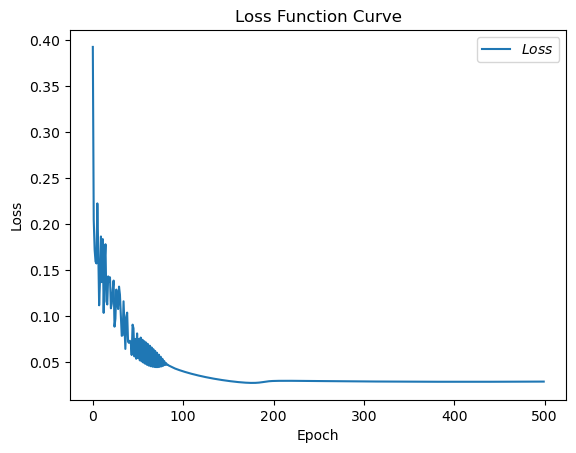

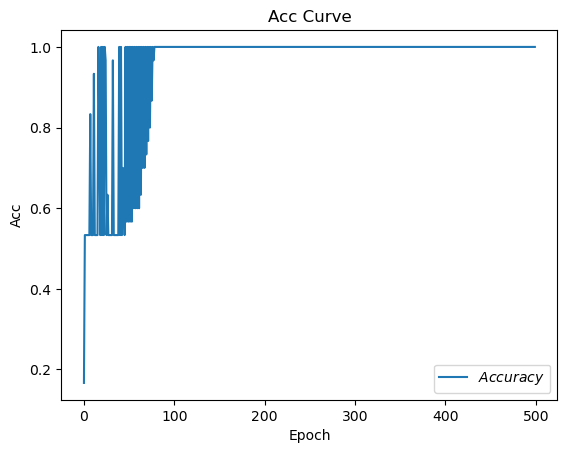

In [48]:
# 利用鸢尾花数据集，实现前向传播、反向传播，可视化loss曲线

# 导入所需模块
import tensorflow as tf
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np
import time

# 导入数据，分别为输入特征和标签
x_data = datasets.load_iris().data 
y_data = datasets.load_iris().target

 # 随机打乱数据（因为原始数据是顺序的，顺序不打乱会影响准确率）
# seed: 随机数种子，是一个整数，当设置之后，每次生成的随机数都一样（为方便教学，以保每位同学结果一致）
np.random.seed(116)  # 使用相同的seed，保证输入特征和标签一一对应
np.random.shuffle(x_data)
np.random.seed(116)
np.random.shuffle(y_data)
tf.random.set_seed(116)

# 将打乱后的数据集分割为训练集和测试集，训练集为前120行，测试集为后30行
x_train = x_data[:-30]
y_train = y_data[:-30]
x_test = x_data[-30:]
y_test = y_data[-30:]

# 转换x的数据类型，否则后面矩阵相乘时会因数据类型不一致报错
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)


# from_tensor_slices函数使输入特征和标签值一一对应。（把数据集分批次，每个批次batch组数据）
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# 生成神经网络的参数，4个输入特征故，输入层为4个输入节点；因为3分类，故输出层为3个神经元
# 用tf.Variable()标记参数可训练
# 使用seed使每次生成的随机数相同（方便教学，使大家结果都一致，在现实使用时不写seed）
w1 = tf.Variable(tf.random.truncated_normal([4, 3], stddev=0.1, seed=1))
b1 = tf.Variable(tf.random.truncated_normal([3], stddev=0.1, seed=1))

lr = 0.1 # 学习率为0.1
train_loss_results = [] # 将每轮的loss记录在此列表中，为后续画loss曲线提供数据
test_acc = [] # 将每轮的acc记录在此列表中，为后续画acc曲线提供数据
epoch = 500 # 循环500轮
loss_all = 0 # 每轮分4个step，loss_all记录四个step生成的4个loss的和

#########################################################################
v_w, v_b = 0, 0
beta = 0.9
#########################################################################

# 训练部分
now_time = time.time()
for epoch in range(epoch): # 数据集级别的循环，每个epoch循环一次数据集
    for step, (x_train, y_train) in enumerate(train_db):
        with tf.GradientTape() as tape: # with结构记录梯度信息
            y = tf.matmul(x_train, w1) + b1 # 神经网络乘加运算
            y = tf.nn.softmax(y) # 使输出y符合概率分布（此操作后与独热码同量级，可相减求loss）
            y_ = tf.one_hot(y_train, depth=3)  # 将标签值转换为独热码格式，方便计算loss和accuracy
            loss = tf.reduce_mean(tf.square(y_ - y))  # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_all += loss.numpy()  # 将每个step计算出的loss累加，为后续求loss平均值提供数据，这样计算的loss更准确
        # 计算loss对各个参数的梯度
        grads = tape.gradient(loss, [w1, b1])
        
        ##########################################
        #rmsprop
        v_w = beta * v_w + (1 - beta) * tf.square(grads[0])
        v_b = beta * v_b + (1 - beta) * tf.square(grads[1])
        w1.assign_sub(lr * grads[0] / tf.sqrt(v_w))
        b1.assign_sub(lr * grads[1] / tf.sqrt(v_b))
        ##########################################
                    
    # 每个epoch，打印loss信息
    print("Epoch:{}, loss: {}".format(epoch, loss_all / 4))
    train_loss_results.append(loss_all / 4) # 将4个step的loss求平均记录在此变量中
    loss_all = 0  # loss_all归零，为记录下一个epoch的loss做准备

    # 测试部分
    # total_correct为预测对的样本个数, total_number为测试的总样本数，将这两个变量都初始化为0
    total_correct, total_number = 0, 0
    for x_test, y_test in test_db:
        # 使用更新后的参数进行预测
        y = tf.matmul(x_test, w1) + b1
        y = tf.nn.softmax(y)
        pred = tf.argmax(y, axis=1) # 返回y中最大值的索引，即预测的分类
        # 将pred转换为y_test的数据类型
        pred = tf.cast(pred, dtype=y_test.dtype)
        # 若分类正确，则correct=1，否则为0，将bool型的结果转换为int型
        correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
        # 将每个batch的correct数加起来
        correct = tf.reduce_sum(correct)
        # 将所有batch中的correct数加起来
        total_correct += int(correct)
        # total_number为测试的总样本数，也就是x_test的行数，shape[0]返回变量的行数
        total_number += x_test.shape[0]
    # 总的准确率等于total_correct/total_number
    acc = total_correct / total_number
    test_acc.append(acc)
    print("Test_acc:", acc)
    print("--------------------------")
total_time = time.time() - now_time
print("total_time", total_time)
    

# 绘制 loss 曲线
plt.title('Loss Function Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Loss')  # y轴变量名称
plt.plot(train_loss_results, label="$Loss$")  # 逐点画出trian_loss_results值并连线，连线图标是Loss
plt.legend()  # 画出曲线图标
plt.show()  # 画出图像

# 绘制 Accuracy 曲线
plt.title('Acc Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Acc')  # y轴变量名称
plt.plot(test_acc, label="$Accuracy$")  # 逐点画出test_acc值并连线，连线图标是Accuracy
plt.legend()
plt.show()

# 本文件较 class1\p45_iris.py 仅添加四处时间记录  用 ##n## 标识
# 请将loss曲线、ACC曲线、total_time记录到 class2\优化器对比.docx  对比各优化器收敛情况

### 6.4 AdaDelta

### 6.5 Adam

Epoch:0, loss: 0.21970458701252937
Test_acc: 0.5333333333333333
--------------------------
Epoch:1, loss: 0.14318205043673515
Test_acc: 0.5333333333333333
--------------------------
Epoch:2, loss: 0.10562838986515999
Test_acc: 0.5666666666666667
--------------------------
Epoch:3, loss: 0.0896413903683424
Test_acc: 0.5333333333333333
--------------------------
Epoch:4, loss: 0.08586997911334038
Test_acc: 0.7333333333333333
--------------------------
Epoch:5, loss: 0.07381817046552896
Test_acc: 0.7666666666666667
--------------------------
Epoch:6, loss: 0.06908280216157436
Test_acc: 0.7666666666666667
--------------------------
Epoch:7, loss: 0.06410512886941433
Test_acc: 0.9666666666666667
--------------------------
Epoch:8, loss: 0.05874997191131115
Test_acc: 0.9333333333333333
--------------------------
Epoch:9, loss: 0.05638519395142794
Test_acc: 1.0
--------------------------
Epoch:10, loss: 0.05255359876900911
Test_acc: 0.9666666666666667
--------------------------
Epoch:11, loss

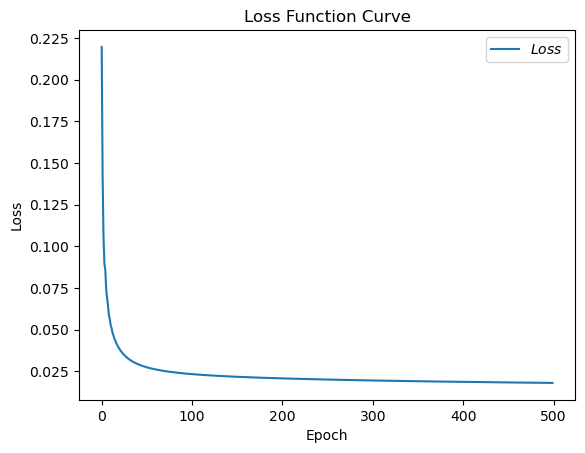

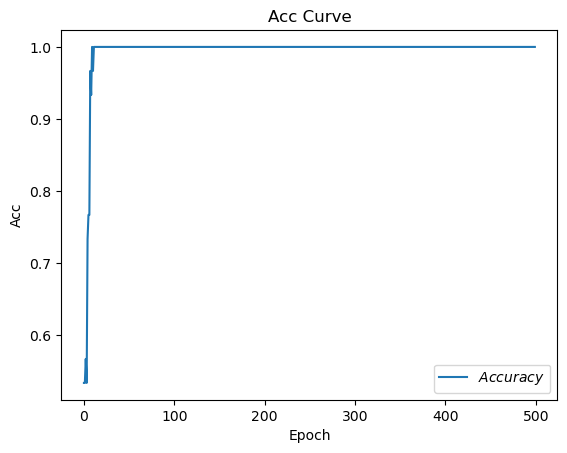

In [49]:
# 利用鸢尾花数据集，实现前向传播、反向传播，可视化loss曲线

# 导入所需模块
import tensorflow as tf
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np
import time

# 导入数据，分别为输入特征和标签
x_data = datasets.load_iris().data 
y_data = datasets.load_iris().target

 # 随机打乱数据（因为原始数据是顺序的，顺序不打乱会影响准确率）
# seed: 随机数种子，是一个整数，当设置之后，每次生成的随机数都一样（为方便教学，以保每位同学结果一致）
np.random.seed(116)  # 使用相同的seed，保证输入特征和标签一一对应
np.random.shuffle(x_data)
np.random.seed(116)
np.random.shuffle(y_data)
tf.random.set_seed(116)

# 将打乱后的数据集分割为训练集和测试集，训练集为前120行，测试集为后30行
x_train = x_data[:-30]
y_train = y_data[:-30]
x_test = x_data[-30:]
y_test = y_data[-30:]

# 转换x的数据类型，否则后面矩阵相乘时会因数据类型不一致报错
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)


# from_tensor_slices函数使输入特征和标签值一一对应。（把数据集分批次，每个批次batch组数据）
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# 生成神经网络的参数，4个输入特征故，输入层为4个输入节点；因为3分类，故输出层为3个神经元
# 用tf.Variable()标记参数可训练
# 使用seed使每次生成的随机数相同（方便教学，使大家结果都一致，在现实使用时不写seed）
w1 = tf.Variable(tf.random.truncated_normal([4, 3], stddev=0.1, seed=1))
b1 = tf.Variable(tf.random.truncated_normal([3], stddev=0.1, seed=1))

lr = 0.1 # 学习率为0.1
train_loss_results = [] # 将每轮的loss记录在此列表中，为后续画loss曲线提供数据
test_acc = [] # 将每轮的acc记录在此列表中，为后续画acc曲线提供数据
epoch = 500 # 循环500轮
loss_all = 0 # 每轮分4个step，loss_all记录四个step生成的4个loss的和

#########################################################################
m_w, m_b = 0, 0
v_w, v_b = 0, 0
beta1, beta2 = 0.9, 0.999
delta_w, delta_b = 0, 0
global_step = 0
#########################################################################

# 训练部分
now_time = time.time()
for epoch in range(epoch): # 数据集级别的循环，每个epoch循环一次数据集
    for step, (x_train, y_train) in enumerate(train_db):
        ###################################################################
        global_step += 1
        ###################################################################
        with tf.GradientTape() as tape: # with结构记录梯度信息
            y = tf.matmul(x_train, w1) + b1 # 神经网络乘加运算
            y = tf.nn.softmax(y) # 使输出y符合概率分布（此操作后与独热码同量级，可相减求loss）
            y_ = tf.one_hot(y_train, depth=3)  # 将标签值转换为独热码格式，方便计算loss和accuracy
            loss = tf.reduce_mean(tf.square(y_ - y))  # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_all += loss.numpy()  # 将每个step计算出的loss累加，为后续求loss平均值提供数据，这样计算的loss更准确
        # 计算loss对各个参数的梯度
        grads = tape.gradient(loss, [w1, b1])
        
        ##########################################
        #adam 
        m_w = beta1 * m_w + (1 - beta) * grads[0]
        m_b = beta1 * v_b + (1 - beta) * grads[1]
        v_w = beta2 * v_w + (1 - beta2) * tf.square(grads[0])
        v_b = beta2 * v_b + (1 - beta2) * tf.square(grads[1])
        
        m_w_correction = m_w / (1 - tf.pow(beta1, int(global_step)))
        m_b_correction = m_b / (1 - tf.pow(beta1, int(global_step)))
        v_w_correction = v_w / (1 - tf.pow(beta2, int(global_step)))
        v_b_correction = v_b / (1 - tf.pow(beta2, int(global_step)))
        
        w1.assign_sub(lr * m_w_correction / tf.sqrt(v_w_correction))
        b1.assign_sub(lr * m_b_correction / tf.sqrt(v_b_correction))
        ##########################################
                    
    # 每个epoch，打印loss信息
    print("Epoch:{}, loss: {}".format(epoch, loss_all / 4))
    train_loss_results.append(loss_all / 4) # 将4个step的loss求平均记录在此变量中
    loss_all = 0  # loss_all归零，为记录下一个epoch的loss做准备

    # 测试部分
    # total_correct为预测对的样本个数, total_number为测试的总样本数，将这两个变量都初始化为0
    total_correct, total_number = 0, 0
    for x_test, y_test in test_db:
        # 使用更新后的参数进行预测
        y = tf.matmul(x_test, w1) + b1
        y = tf.nn.softmax(y)
        pred = tf.argmax(y, axis=1) # 返回y中最大值的索引，即预测的分类
        # 将pred转换为y_test的数据类型
        pred = tf.cast(pred, dtype=y_test.dtype)
        # 若分类正确，则correct=1，否则为0，将bool型的结果转换为int型
        correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
        # 将每个batch的correct数加起来
        correct = tf.reduce_sum(correct)
        # 将所有batch中的correct数加起来
        total_correct += int(correct)
        # total_number为测试的总样本数，也就是x_test的行数，shape[0]返回变量的行数
        total_number += x_test.shape[0]
    # 总的准确率等于total_correct/total_number
    acc = total_correct / total_number
    test_acc.append(acc)
    print("Test_acc:", acc)
    print("--------------------------")
total_time = time.time() - now_time
print("total_time", total_time)
    

# 绘制 loss 曲线
plt.title('Loss Function Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Loss')  # y轴变量名称
plt.plot(train_loss_results, label="$Loss$")  # 逐点画出trian_loss_results值并连线，连线图标是Loss
plt.legend()  # 画出曲线图标
plt.show()  # 画出图像

# 绘制 Accuracy 曲线
plt.title('Acc Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Acc')  # y轴变量名称
plt.plot(test_acc, label="$Accuracy$")  # 逐点画出test_acc值并连线，连线图标是Accuracy
plt.legend()
plt.show()

# 本文件较 class1\p45_iris.py 仅添加四处时间记录  用 ##n## 标识
# 请将loss曲线、ACC曲线、total_time记录到 class2\优化器对比.docx  对比各优化器收敛情况

### 6.6 优化器选择

### 6.7 优化算法的常用tricks

## 参考链接

## 附录：常用 TensorFlow 及代码实现

### 学习率策略

In [ ]:
import tensorflow as tf
w = tf.Variable(tf.constant(5, dtype=tf.float32))

epoch = 100
LR_BASE = 0.2 # 最初学习率
LR_DECAY = 0.99 # 学习率衰减率
LR_STEP = 1 # 喂入多少轮BATCH_SIZE 后，更新一次学习率
for epoch in range(epoch): # for epoch 定义顶层循环，表示对数据集循环epoch次，此例数据集数据仅有1个w,初始化时候constant赋值为5，循环100次迭代。
    lr = LR_BASE * LR_DECAY ** (epoch / LR_STEP)
    with tf.GradientTape() as tape: # with结构到grads框起了梯度的计算过程。
        loss = tf.square(w + 1)
    grads = tape.gradient(loss, w) # .gradient函数告知谁对谁求导
    
    w.assign_sub(lr * grads)  # .assign_sub 对变量做自减 即：w -= lr*grads 即 w = w - lr*grads
    print("After %s epoch ,w is %f, loss is %f, lr is %f" % (epoch, w.numpy(), loss, lr))

指数衰减学习率策略

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt 

N = 100
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
0.5,
decay_steps=10,
decay_rate=0.9,
staircase=False)
y = []
for global_step in range(N):
    lr = lr_schedule(global_step)
    y.append(lr)
x = range(N)
plt.figure(figsize=(8,6))
plt.plot(x, y, 'r-')
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('ExponentialDecay')
plt.show()

分段衰减学习率策略

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

N = 400
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries = [100, 200, 300],
    values = [0.1, 0.05, 0.025, 0.001]
)
y = []
for global_step in range(N):
    lr = lr_schedule(global_step)
    y.append(lr)
 
x = range(N)   
# plt.figure(figsize=(8,6))
plt.plot(x, y, 'r-')
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('ExponentialDecay')
plt.show()

### 激活函数

#### tf.math.sigmoid

In [ ]:
import tensorflow as tf

x = tf.constant([1., 2., 3.])
print(tf.math.sigmoid(x))

In [ ]:
print(1/(1 + tf.math.exp(-x)))

#### tf.math.tanh

In [ ]:
x = tf.constant([-float("inf"), -5, -0.5, 1, 1.2, 2, 3, float("inf")])
print(tf.math.tanh(x))

In [36]:
# 等价实现
# print((1 - tf.math.exp(-2*x))/(1 + tf.math.exp(-2*x)))
print((tf.math.exp(x) - tf.math.exp(-x))/(tf.math.exp(x) + tf.math.exp(-x)))


tf.Tensor(
[        nan -0.9999091  -0.46211714  0.7615942   0.83365464  0.9640275
  0.9950547          nan], shape=(8,), dtype=float32)


#### tf.nn.relu

In [ ]:
print(tf.nn.relu([-2., 0., -0., 3.]))

#### tf.nn.leaky_relu

In [ ]:
print(tf.nn.leaky_relu([-2., 0., -0., 3.]))

#### tf.nn.softmax

In [ ]:
logits = tf.constant([4., 5., 1.])
print(tf.nn.softmax(logits))

In [ ]:
# 等价实现
print(tf.exp(logits) / tf.reduce_sum(tf.exp(logits)))

### 损失函数

#### tf.keras.losses.MSE

In [ ]:
y_true = tf.constant([0.5, 0.8])
y_pred = tf.constant([1.0, 1.0])
print(tf.keras.losses.MSE(y_true, y_pred))

In [ ]:
# 等价实现
print(tf.reduce_mean(tf.square(y_true, y_pred)))

#### tf.keras.losses.categorical_crossentropy

In [23]:
y_true = [1, 0, 0]
y_pred1 = [0.5, 0.4, 0.1]
y_pred2 = [0.8, 0.1, 0.1]
print(tf.keras.losses.categorical_crossentropy(y_true, y_pred1))
print(tf.keras.losses.categorical_crossentropy(y_true, y_pred2))

tf.Tensor(0.6931472, shape=(), dtype=float32)
tf.Tensor(0.22314353, shape=(), dtype=float32)


In [25]:
# 等价实现
print(-tf.reduce_sum(y_true * tf.math.log(y_pred1)))
print(-tf.reduce_sum(y_true * tf.math.log(y_pred2)))

tf.Tensor(0.6931472, shape=(), dtype=float32)
tf.Tensor(0.22314353, shape=(), dtype=float32)


#### tf.nn.softmax_cross_entropy_with_logits


In [26]:
labels = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]]
logits = [[4.0, 2.0, 1.0], [0.0, 5.0, 1.0]]
print(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))


tf.Tensor([0.16984604 0.02474492], shape=(2,), dtype=float32)


In [28]:
# 等价实现
print(-tf.reduce_sum(labels * tf.math.log(tf.nn.softmax(logits)), axis=1))

tf.Tensor([0.16984606 0.02474495], shape=(2,), dtype=float32)


In [29]:
tf.nn.softmax(logits)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.8437947 , 0.11419519, 0.04201007],
       [0.00657326, 0.9755587 , 0.01786798]], dtype=float32)>

In [31]:
labels * tf.math.log(tf.nn.softmax(logits))

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-0.16984606, -0.        , -0.        ],
       [-0.        , -0.02474495, -0.        ]], dtype=float32)>

#### tf.nn.sparse_softmax_cross_entropy_with_logits

In [34]:
labels = [0, 1]
logits = [[4.0, 2.0, 1.0], [0.0, 5.0, 1.0]]
print(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))


tf.Tensor([0.16984604 0.02474492], shape=(2,), dtype=float32)


In [35]:
# 等价实现
print(-tf.reduce_sum(tf.one_hot(labels, tf.shape(logits)[1]) * tf.math.log(tf.nn.softmax(logits)), axis=1))

tf.Tensor([0.16984606 0.02474495], shape=(2,), dtype=float32)


### 其它

In [ ]:
import tensorflow as tf
from sklearn import datasets
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# 加载数据集
iris = datasets.load_iris()
X = iris.data
y = to_categorical(iris.target, 3)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 定义模型结构
model = Sequential()
model.add(Dense(10, input_dim=4, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='softmax'))

# 编译模型
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 训练模型
model.fit(X_train, y_train, epochs=200, batch_size=10, verbose=1)

# 评估模型
loss, accuracy = model.evaluate(X_test, y_test)
print('\nLoss: %.2f, Accuracy: %.2f%%' % (loss, accuracy*100))


#### tf.cast
转换数据（张量）类型

In [ ]:
import tensorflow as tf
x = tf.constant([1.8, 2.2], dtype=tf.float32)
print(tf.cast(x, tf.int32))

#### tf.random.normal
生成服从正态分布的随机值。

In [ ]:
import tensorflow as tf
tf.random.normal([3, 5])

#### tf.where
根据condition，取x或y中的值。如果为True，对应位置取x的值；如果为False，对应位置取y的值。

In [ ]:
import tensorflow as tf
tf.where([True, False, True, False], [1, 2, 3, 4], [5, 6, 7, 8])

In [ ]:
a = tf.constant([1, 2, 3 ,1, 1])
b = tf.constant([0, 1, 3, 4, 5])
c = tf.where(tf.greater(a, b), a, b)
c

In [ ]:
import numpy as np
rdm = np.random.RandomState(seed=1)
a = rdm.rand()
b = rdm.rand(2, 3)
print("a:", a)
print("b:", b)

#### vstack

In [ ]:
import numpy as np
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
c = np.vstack((a, b))
print("c:", c)

#### mgrid

In [ ]:
import numpy as np
import tensorflow as tf

# 生成等间隔数值点
x, y = np.mgrid[1:3:1, 2:4:0.5]
# 将x, y拉直，并合并配对为二维张量，生成二维坐标点
grid = np.c_[x.ravel(), y.ravel()]
print("x:", x)
print("y:", y)
print("x.ravel():", x.ravel())
print("y.ravel():", y.ravel())
print("grid:", grid)